# Step 2: SEM Fit Score

In [1]:
# | output: false

# Import the required packages
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from datetime import datetime
import circumplex
import json
from scipy.spatial import procrustes
from tensorly.metrics.factors import congruence_coefficient

today = datetime.today().strftime("%Y-%m-%d")

In [2]:
# | warning: false

# Define the scales and angles to be used
scales = ["PAQ1", "PAQ2", "PAQ3", "PAQ4", "PAQ5", "PAQ6", "PAQ7", "PAQ8"]
eq_angles = [0, 45, 90, 135, 180, 225, 270, 315]

# Define the data and output folders
data_folder = Path("../data/")
output_folder = Path(f"../outputs/{today}")

# Load data
satp = pd.read_excel(data_folder / "SATP Dataset v1.4.xlsx")

In [3]:
# Load the results from the latest SEM analysis
sem_res = pd.read_csv(output_folder / "sem-fit-ipsatized.csv")
sem_res.drop("Unnamed: 0", axis=1, inplace=True)

# In some cases, the SEM flips the angles
# (i.e. vibrant is at 315 degrees instead of 45).
# This function checks for this and corrects it,
# to ensure all the scales are in the correct order,
# but without changing the relationship between the angles,
# as identified by the SEM.)

# First, get the angles from the SEM results
ang_df = sem_res[sem_res["Model Type"] == "Equal comm."][["Language"] + scales]
ang_df.set_index("Language", inplace=True)


def check_inverse_angles(language_angles):
    """Check if the angles are inverse"""
    if (
        language_angles[1] > language_angles[2]
        or language_angles[2] > language_angles[3]
    ):
        return True
    else:
        return False


# Then, check if the angles are inverse, and if so, correct them
for lang in ang_df.index:
    if check_inverse_angles(ang_df.loc[lang].values):
        ang_df.loc[lang][1:] = 360 - ang_df.loc[lang][1:]

ang_dict = ang_df.T.to_dict(orient="list")
ang_dict

{'eng': [0.0, 46.0, 94.0, 138.0, 177.0, 231.0, 275.0, 340.0],
 'arb': [0.0, 36.0, 45.0, 135.0, 167.0, 201.0, 242.0, 308.0],
 'cmn': [0.0, 18.0, 38.0, 154.0, 171.0, 196.0, 217.0, 318.0],
 'deu': [0.0, 64.0, 97.0, 132.0, 182.0, 254.0, 282.0, 336.0],
 'ell': [0.0, 72.0, 86.0, 133.0, 161.0, 233.0, 267.0, 328.0],
 'fra': [0.0, 69.0, 102.0, 129.0, 173.0, 246.0, 275.0, 325.0],
 'hrv': [0.0, 84.0, 93.0, 160.0, 173.0, 243.0, 273.0, 354.0],
 'ind': [0.0, 53.0, 104.0, 123.0, 139.0, 202.0, 284.0, 308.0],
 'ita': [0.0, 57.0, 104.0, 142.0, 170.0, 274.0, 285.0, 336.0],
 'jpn': [0.0, 46.0, 101.0, 138.0, 159.0, 271.0, 288.0, 339.0],
 'kor': [0.0, 56.0, 90.0, 124.0, 151.0, 251.0, 275.0, 288.0],
 'nld': [0.0, 43.0, 111.0, 125.0, 174.0, 257.0, 307.0, 341.0],
 'por': [0.0, 81.0, 121.0, 140.0, 171.0, 252.0, 275.0, 334.0],
 'spa': [0.0, 41.0, 103.0, 147.0, 174.0, 238.0, 279.0, 332.0],
 'swe': [0.0, 66.0, 87.0, 146.0, 175.0, 249.0, 275.0, 335.0],
 'tur': [0.0, 55.0, 97.0, 106.0, 157.0, 254.0, 289.0, 313.0]}

In [4]:
len(ang_dict)

16

### Calculate the SEM fit score

The SEM fit score is calculated by counting the number of fit indices that pass the pre-defined threshold. The thresholds are defined in the first part of the code. The thresholds are based on the thresholds used by @Rogoza2021three.

The first part of the code defines a dictionary named `thresholds` which contains the thresholds for different fit criteria used in SEM. These criteria include p-value (p), Comparative Fit Index (CFI), Goodness of Fit Index (GFI), Adjusted Goodness of Fit Index (AGFI), Standardized Root Mean Square Residual (SRMR), and others.

The `incl_in_score` list is used to select which criteria will be included in the final score calculation. The `pass_thresh` and `tent_thresh` variables define the thresholds for passing and tentative passing scores, respectively.

The next part of the code calculates whether each SEM result passes the defined thresholds for each criterion. This is done by comparing the SEM result for each criterion to its respective threshold. The results of these comparisons are stored as boolean values in new columns in the `sem_res` DataFrame.

The final score for each SEM result is then calculated by summing the number of criteria each result passes. This score is stored as an integer in a new column in the `sem_res` DataFrame. The passing column categorizes each SEM result as 'Fail', 'Tentative', or 'Pass' based on its final score.

Finally, the results are saved to an Excel file and a subset of the results is displayed. The subset includes only the results for the "Equal comm." model type and is sorted by score in descending order.

In [5]:
# Define the thresholds for the SEM fit criteria
thresholds = {
    "CFI": 0.92,  #  Moshona et al 2023, Hu & Bentler 1999
    "GFI": 0.90,  # Rogoza 2021
    "SRMR": 0.08,  # Moshona et al 2023, Tarlao et al 2021, West (2023), Hu & Bentler (1999)
    # Removed RMSEA at the suggestion of
    # West, S.G., Wu, W., McNeish, D., & Savord, A. (2023).
    # Model Fit in Structural Equation Modeling.
    # In R.H. Hoyle, Handbook of structural equation modeling.
}

# Choose which criteria to include in the final score
# incl_in_score = ['CFI', 'GFI', 'AGFI', 'RMSEA'] # Rogoza
incl_in_score = ["CFI", "GFI", "SRMR"]

# Define the thresholds for the final score
pass_thresh = 3

# Calculate the final score
# CircE provides at most 3 digits after the decimal point,
# in some cases this is not enough to distinguish between
# 
sem_res["CFI_pass"] = sem_res["CFI"] >= thresholds["CFI"]
sem_res["GFI_pass"] = sem_res["GFI"] >= thresholds["GFI"]
sem_res["SRMR_pass"] = sem_res["SRMR"] < thresholds["SRMR"]

sem_res["Score"] = sem_res[[x + "_pass" for x in incl_in_score]].sum(axis=1)
sem_res["Score"] = sem_res["Score"].astype(int)
sem_res["passing"] = pd.cut(
    sem_res["Score"], bins=[0, pass_thresh, 7], labels=["Fail", "Pass"], right=False
)
# Save the results
sem_res.to_excel(output_folder / f"sem-fit-results.xlsx", index=False)

In [6]:
# | label: tbl-sem-res
# | tbl-cap: SEM fit results

sem_scores = sem_res[
    ["Language", "Model Type", "n", "m", "CFI", "GFI", "SRMR", "Score", "passing"]
].loc[sem_res["Model Type"] == "Equal comm."].sort_values("Language", ascending=True)
sem_scores.to_csv(output_folder / f"sem-scores.csv", index=False)
sem_scores

,Language,Model Type,n,m,CFI,GFI,SRMR,Score,passing
5,arb,Equal comm.,809,3,0.971,0.969,0.044,3,Pass
9,cmn,Equal comm.,1832,3,0.960,0.954,0.044,3,Pass
13,deu,Equal comm.,810,3,0.943,0.915,0.059,3,Pass
17,ell,Equal comm.,810,3,0.928,0.934,0.079,3,Pass
1,eng,Equal comm.,864,3,0.934,0.907,0.052,3,Pass
21,fra,Equal comm.,891,3,0.919,0.913,0.098,1,Fail
25,hrv,Equal comm.,864,3,0.949,0.926,0.065,3,Pass
29,ind,Equal comm.,891,3,0.933,0.923,0.078,3,Pass
33,ita,Equal comm.,810,3,0.944,0.932,0.069,3,Pass
37,jpn,Equal comm.,917,3,0.892,0.896,0.087,0,Fail


In [7]:
passing = (
    sem_res.loc[sem_res["Model Type"] == "Equal comm."]
    .query("passing != 'Fail'")["Language"]
    .values
)

satp = satp.query("Language in @passing")

In [8]:
len(satp.Language.unique())

12

### Steps 3 and 4: Accurately locating circumplex items within each language

For this analysis, we use a custom Python package developed for this paper, called `circumplex` which can be installed from PyPI.

The process to do this is as follows:

1.  For both the reference and test circumplex, calculate the mean value of each scale for each recording.
2.  Calculate the SSM correlation between each scale of the reference circumplex and the test circumplex, in our case using the corrected angles.
3.  Test the congruence betwen the empirical locations and theoretical expectations using the Procrustes congruence test [@Rogoza2021three].

We will be using the full dataset as the reference set and the data from each translation as the test set. This effectively means that we are testing whether each translation is able to locate the circumplex structure of the soundscape survey, consistently across all languages.

#### Congruence

What @Rogoza2021three (and Orthosim) refer to as Tucker's Congruence Coefficient is also commonly referred to as the cosine similarity (see the [Tensorly documentation](https://tensorly.org/stable/modules/generated/tensorly.metrics.factors.congruence_coefficient.html)). We therefore use the sklearn implementation of cosine similarity to calculate the congruence between the empirical locations and theoretical expectations. This produces a matrix of cosine similarity values, which we then use to calculate the mean congruence, to match the model congruence from @Rogoza2021three.

We can confirm the equivalence of this method by comparing with the results from @Rogoza2021three 's Orthosim analysis:

In [9]:
def congruence(data1, data2, metric: ["cosine", "euclidean"] = "cosine"):
    from sklearn.metrics.pairwise import cosine_similarity
    from scipy.spatial.distance import cdist

    if metric == "cosine":
        sim = cosine_similarity(data1, data2)
    elif metric == "euclidean":
        sim = 1 - cdist(data1, data2, metric=metric)
    else:
        raise ValueError("metric must be 'cosine' or 'euclidean'")
    # Get the diagonal values which compare against the appropriate angles
    cong_vals = np.diag(sim)
    return np.mean(cong_vals), cong_vals


# Data from Rogoza
data2 = np.array([[-0.59, -0.8], [-1, -0.05], [-0.5, 0.87]])
data1 = np.array([[-0.71, -0.71], [-1, 0], [-0.71, 0.71]])

model_congruence, scale_congruence = congruence(data1, data2)

print("Model Congruence == 0.984: ", np.round(model_congruence, 3) == 0.984)
print("Vulnerability Congruence == 0.99: ", np.round(scale_congruence[0], 2) == 0.99)
print("Antagonism Congruence == 1.0: ", np.round(scale_congruence[1], 2) == 1.0)
print("Grandiosity Congruence == 0.97: ", np.round(scale_congruence[2], 2) == 0.97)

Model Congruence == 0.984:  True
Vulnerability Congruence == 0.99:  True
Antagonism Congruence == 1.0:  True
Grandiosity Congruence == 0.97:  True


#### Procrustes

However, it appears that, despite @Rogoza2021three 's description, this method is not actually based on a Procrustes analysis. The equivalent distance metric from a Procrustes method would be the rotational-based Procrustes distance, i.e. the squared Froebenius norm of the difference between the two orthogonal matrices. See @Andreella2023Procrustes:

> Instead, the second distance exploits the orthogonal matrix parameters solution of the Procrustes problem. The rotational-based distance computes the squared Frobenius distance between these estimated orthogonal matrices. As we will see, this metric measures the level of dissimilarity/similarity in orientation between matrices/subjects before functional alignment.

As such, we can also calculate this distance using the [`procrustes` package](https://procrustes.qcdevs.org/api/utils.html#procrustes.utils.ProcrustesResult):

In [10]:
def procrustes_distance(
    data1, data2, procrustes_type="orthogonal", translate=True, scale=True
):
    if procrustes_type == "orthogonal":
        from procrustes import orthogonal

        pro_res = orthogonal(data1, data2, translate=translate, scale=scale)
    elif procrustes_type == "rotational":
        from procrustes import rotational

        pro_res = rotational(data1, data2, translate=translate, scale=scale)
    elif procrustes_type == "generic":
        from procrustes import generic

        pro_res = generic(data1, data2, translate=translate, scale=scale)
    return pro_res.error

In [11]:
def prepare_congruence_matrices(ssm_table, target_angles=eq_angles):
    """Prepare the congruence matrices for the SSM results"""
    # Get the data from the SSM table
    # data2 = np.array((np.cos(np.deg2rad(ssm_table['displacement'])), np.sin(np.deg2rad(ssm_table['displacement'])))).T
    data2 = ssm_table[["xval", "yval"]].values
    # Get the data from the target angles
    data1 = np.ones_like(data2)
    data1[:, 0] = np.cos(np.deg2rad(target_angles))
    data1[:, 1] = np.sin(np.deg2rad(target_angles))

    return data1, data2

Based on the proof given in @Bakhtiar2015symmetrical, given that the input matrices are scaled (i.e. `rotational(scale=True)`), then the Procrustes distance is a true distance measure which obeys $0 < p(X, Y) < 1$ [@Bakhtiar2015symmetrical]. Therefore we can convert the Procrustes distance to a similarity measure by subtracting it from 1.

In [12]:
overall_means = satp.groupby(["Recording"])[scales].mean().reset_index(drop=True)

lang_rec_means = satp.groupby(["Language", "Recording"])[scales].mean()
lang_rec_means.reset_index(inplace=True)


def test_language_locations(
    test_lang_means,
    test_lang,
    test_angles,
    target_angles=eq_angles,
    scales=("PAQ1", "PAQ2", "PAQ3", "PAQ4", "PAQ5", "PAQ6", "PAQ7", "PAQ8"),
):
    """Test the congruence of the language locations with the target angles"""
    test_res = []
    for scale in scales:
        corrs = test_lang_means.corrwith(overall_means[scale])
        ssm_res = circumplex.SSMParams(
            corrs,
            scales,
            test_angles,
            scale,
        )
        test_res.append(ssm_res)

    test_ssm = circumplex.SSMResults(test_res)

    data1, data2 = prepare_congruence_matrices(
        test_ssm.table, target_angles=target_angles
    )
    test_model_congruence, test_scale_congruences = congruence(
        data1, data2, metric="cosine"
    )
    pro_sim = 1 - procrustes_distance(data1, data2, procrustes_type="rotational")
    return test_ssm, test_model_congruence, test_scale_congruences, pro_sim


locating_corr_angles = {}
locating_eq_angles = {}
for test_lang in lang_rec_means.Language.unique():
    test_lang_means = lang_rec_means.query("Language == @test_lang")[
        scales
    ].reset_index(drop=True)

    locating_eq_angles[test_lang] = test_language_locations(
        test_lang_means, test_lang, test_angles=eq_angles, target_angles=eq_angles
    )
    locating_corr_angles[test_lang] = test_language_locations(
        test_lang_means,
        test_lang,
        test_angles=ang_dict[test_lang],
        target_angles=eq_angles,
    )

### Step 3 Results

In [13]:
# | label: tbl-corr-angles-fit
# | tbl-cap: Fit results for locating the general circumplex within each language
fit_results = pd.DataFrame.from_dict(
    {key: locating_corr_angles[key][0].table.r2 for key in locating_corr_angles.keys()}
).T
fit_results.round(3)

,PAQ1,PAQ2,PAQ3,PAQ4,PAQ5,PAQ6,PAQ7,PAQ8
arb,0.998,0.999,0.995,0.995,0.998,0.999,0.997,0.995
cmn,0.997,0.996,0.989,0.993,0.999,0.999,0.990,0.993
deu,0.998,0.999,0.999,0.998,0.998,0.998,0.999,0.998
ell,0.998,0.996,0.998,0.998,0.997,0.998,0.996,0.997
eng,0.997,0.998,0.999,0.996,0.997,0.999,0.998,0.994
hrv,0.997,0.997,0.994,0.995,0.997,0.998,0.995,0.991
ind,0.996,0.998,0.998,0.998,0.996,0.992,0.999,0.996
ita,0.895,0.996,0.998,0.986,0.980,0.990,0.996,0.978
nld,0.993,0.998,0.999,0.998,0.998,0.996,0.999,0.999
spa,0.998,0.996,0.998,0.998,0.998,0.996,0.998,0.999


### Step 4 Results

In [14]:
# | label: tbl-correspondence
# | tbl-cap: Correspondence between the general circumplex and the language-specific circumplex

congruence_df = pd.DataFrame(
    {
        "Language": list(locating_eq_angles.keys()),
        "Eq Ang Model": [x[1] for x in locating_eq_angles.values()],
        "Corr Ang Model": [x[1] for x in locating_corr_angles.values()],
        "Eq Ang Procrustes": [x[3] for x in locating_eq_angles.values()],
        "Corr Ang Procrustes": [x[3] for x in locating_corr_angles.values()],
    }
)
congruence_df.round(3)

,Language,Eq Ang Model,Corr Ang Model,Eq Ang Procrustes,Corr Ang Procrustes
0,arb,0.990,0.941,0.980,0.984
1,cmn,0.931,0.992,0.879,0.990
2,deu,0.986,0.960,0.976,0.984
3,ell,0.986,0.990,0.973,0.980
4,eng,0.989,0.979,0.984,0.984
5,hrv,0.990,0.971,0.983,0.986
6,ind,0.964,0.949,0.938,0.983
7,ita,0.986,0.953,0.976,0.975
8,nld,0.980,0.974,0.942,0.979
9,spa,0.987,0.983,0.969,0.980


### Profile Plots

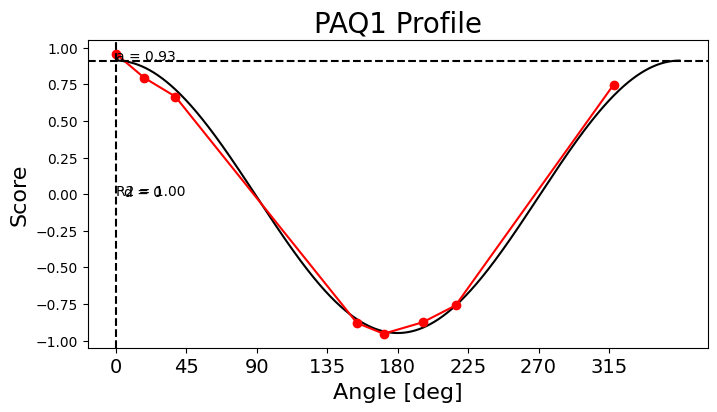

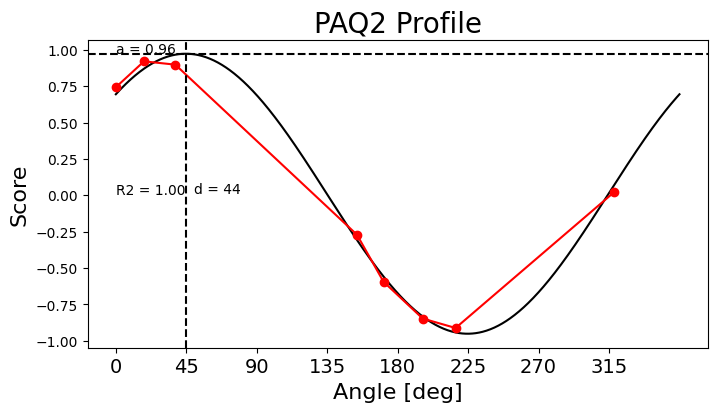

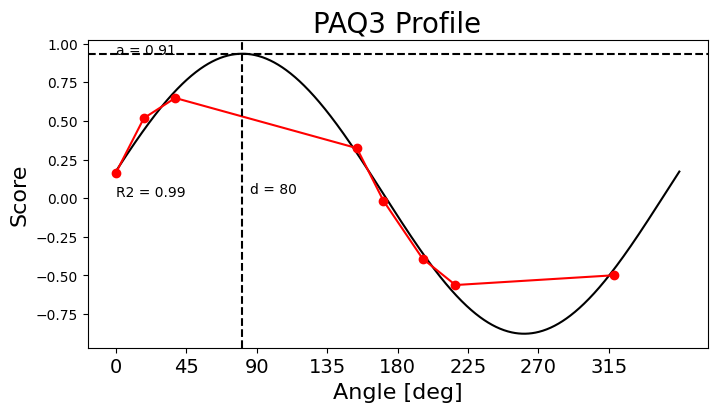

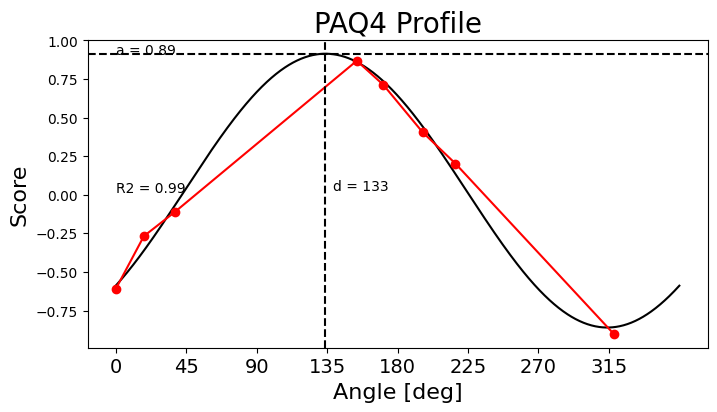

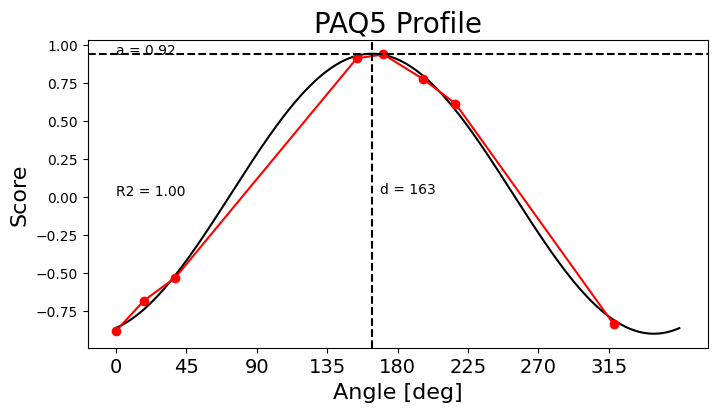

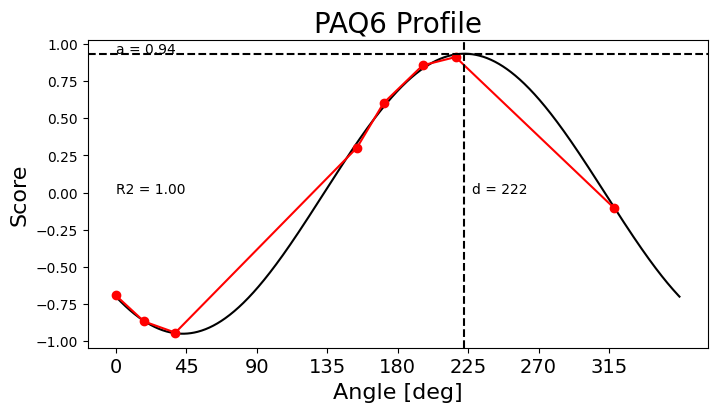

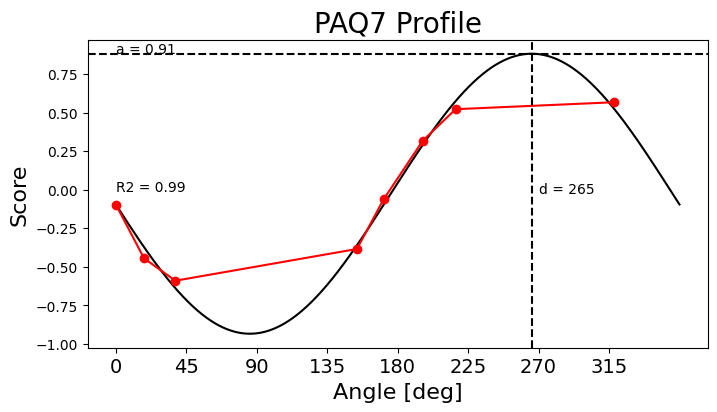

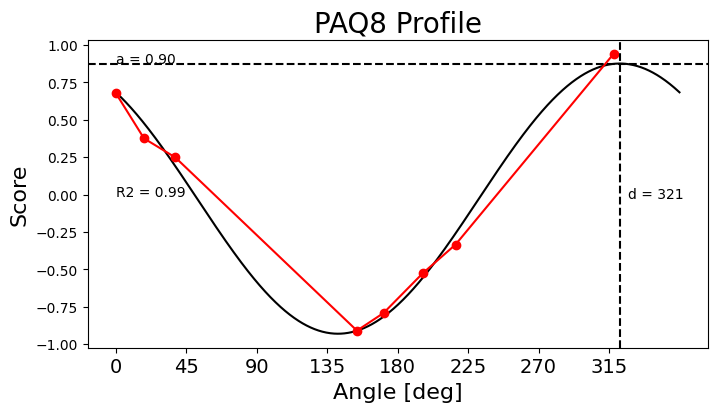

In [15]:
# | label: fig-profile-plots
# | fig-cap: Profile plots for the Mandarin (cmn) translation
# | layout-nrow: 2
# | layout-ncol: 4
# | fig-subcap:
# |   - PAQ1
# |   - PAQ2
# |   - PAQ3
# |   - PAQ4
# |   - PAQ5
# |   - PAQ6
# |   - PAQ7
# |   - PAQ8

for res in locating_corr_angles["cmn"][0].results:
    res.profile_plot()
    plt.show()

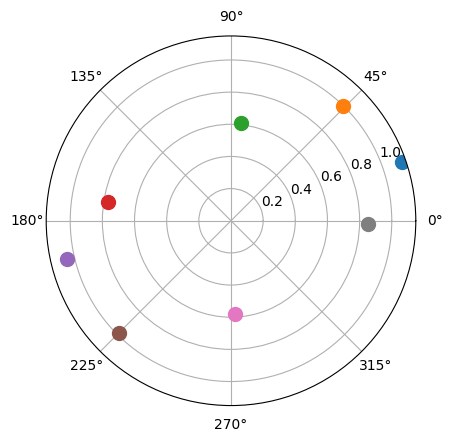

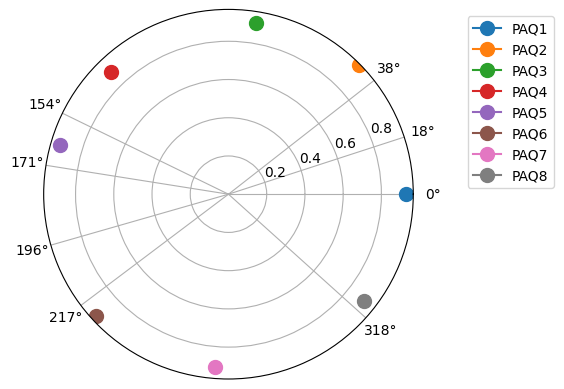

In [16]:
# | label: fig-cmn-correspondence
# | layout-ncol: 2
# | fig-cap: "Locating the  language-specific circumplex for Mandarin, using equal angles and corrected angles"
# | fig-subcap:
# |   - "Equal angles"
# |   - "Corrected angles"

from matplotlib import colormaps

fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
colors = colormaps.get_cmap("tab10").colors
colors = iter(colors)
for res in locating_eq_angles["cmn"][0].results:
    ax.plot(
        np.deg2rad(res.displacement),
        res.amplitude,
        color=next(colors),
        marker="o",
        markersize=10,
        label=res.label,
    )

# locating_eq_angles['cmn'][0].plot(legend=False)
plt.show()
# locating_corr_angles['cmn'][0].plot()

fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
colors = colormaps.get_cmap("tab10").colors
colors = iter(colors)
for res in locating_corr_angles["cmn"][0].results:
    ax.plot(
        np.deg2rad(res.displacement),
        res.amplitude,
        color=next(colors),
        marker="o",
        markersize=10,
        label=res.label,
    )
ax.set_thetagrids(locating_corr_angles["cmn"][0].results[0].angles)
ax.legend(loc="upper right", bbox_to_anchor=(1.4, 1.0))
plt.show()

## Using the corrected angles for ISO 12913-3 and @Mitchell2022How style analysis


In [17]:
import soundscapy as sspy


def adj_angle_iso_coords(data: pd.DataFrame, angles, scale=100):
    isopl = data.apply(
        lambda x: adj_iso_pl(x[scales].values, angles, scale=scale), axis=1
    )
    isoev = data.apply(
        lambda x: adj_iso_ev(x[scales].values, angles, scale=scale), axis=1
    )
    return isopl, isoev


def adj_iso_pl(values, angles, scale=None):
    # scale = range of input values (e.g. 0-100)
    # The scaling factor was derived by comparing to 
    # the scaling from the ISO method. Confirmed to be 
    # the same value when using equal angles.
    # 100 * sum of abs values of the loading factors / 2
    iso_pl = np.sum(
        [np.cos(np.deg2rad(angle)) * values[i] for i, angle in enumerate(angles)]
    )
    if scale:
        iso_pl = iso_pl / (
            scale / 2 * np.sum(np.abs([np.cos(np.deg2rad(angle)) for angle in angles]))
        )
    return iso_pl


def adj_iso_ev(values, angles, scale=None):
    iso_ev = np.sum(
        [np.sin(np.deg2rad(angle)) * values[i] for i, angle in enumerate(angles)]
    )
    if scale:
        iso_ev = iso_ev / (
            scale / 2 * np.sum(np.abs([np.sin(np.deg2rad(angle)) for angle in angles]))
        )
    return iso_ev

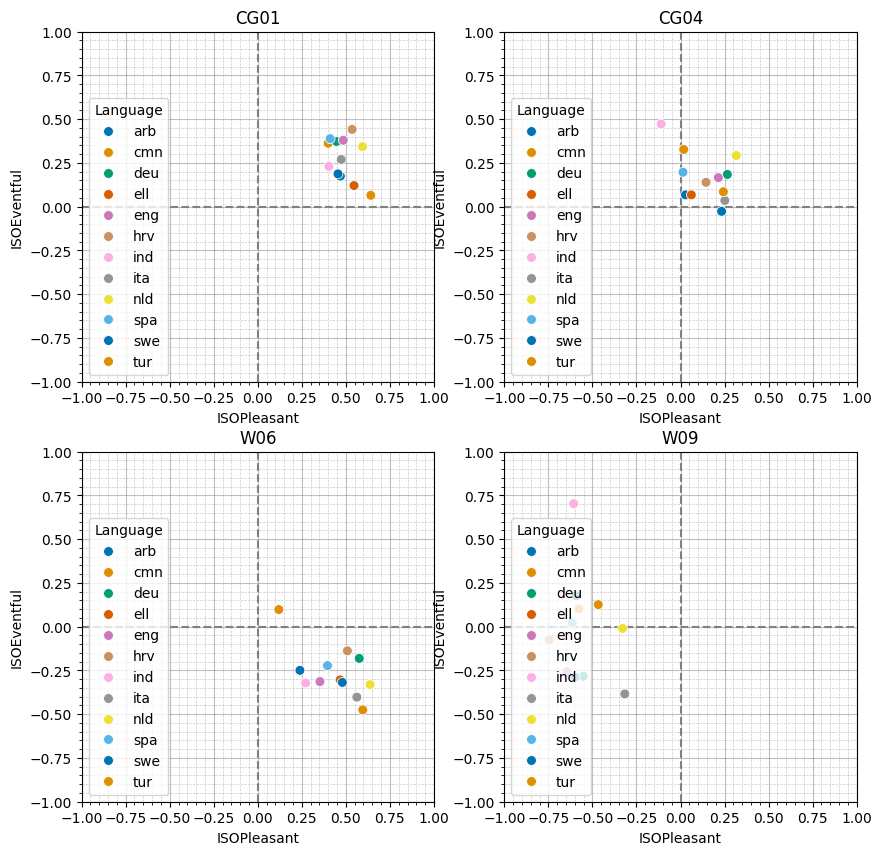

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, rec in enumerate(["CG01", "CG04", "W06", "W09"]):
    cg01 = satp.query("Recording == @rec")
    cg01_res = {}
    for lang in cg01.Language.unique():
        cg01_lang = cg01.query("Language == @lang")
        isopl, isoev = adj_angle_iso_coords(cg01_lang, angles=ang_dict[lang])
        cg01_res[lang] = {
            "Language": lang,
            "ISOPleasant": np.mean(isopl),
            "ISOEventful": np.mean(isoev),
        }
        # print(np.mean(isopl), np.mean(isoev))
    cg01_res = pd.DataFrame.from_dict(cg01_res, orient="index")
    sspy.plotting.scatter(
        cg01_res, hue="Language", s=50, title=rec, ax=axes.flatten()[i]
    )

<Axes: title={'center': 'W06 - Adjusted Angles'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

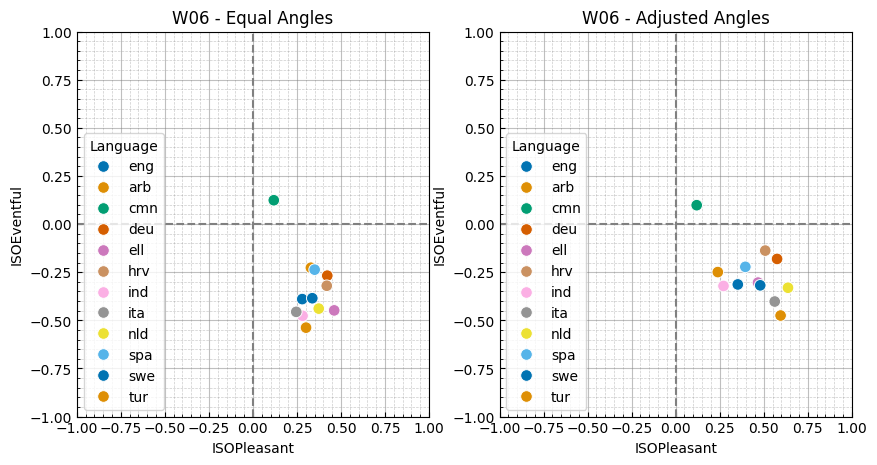

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
cg04 = satp.query("Recording == 'W06'")

cg04_res = {}
for lang in passing:
    cg04_lang = cg04.query("Language == @lang")
    isopl, isoev = adj_angle_iso_coords(cg04_lang, angles=eq_angles)
    cg04_res[lang] = {
        "Language": lang,
        "ISOPleasant": np.mean(isopl),
        "ISOEventful": np.mean(isoev),
    }
    # print(np.mean(isopl), np.mean(isoev))
cg04_res = pd.DataFrame.from_dict(cg04_res, orient="index")
sspy.plotting.scatter(
    cg04_res, hue="Language", s=70, title="W06 - Equal Angles", ax=axes.flatten()[0]
)

cg04_res = {}
for lang in passing:
    cg04_lang = cg04.query("Language == @lang")
    isopl, isoev = adj_angle_iso_coords(cg04_lang, angles=ang_dict[lang])
    cg04_res[lang] = {
        "Language": lang,
        "ISOPleasant": np.mean(isopl),
        "ISOEventful": np.mean(isoev),
    }
    # print(np.mean(isopl), np.mean(isoev))
cg04_res = pd.DataFrame.from_dict(cg04_res, orient="index")
sspy.plotting.scatter(
    cg04_res, hue="Language", s=70, title="W06 - Adjusted Angles", ax=axes.flatten()[1]
)

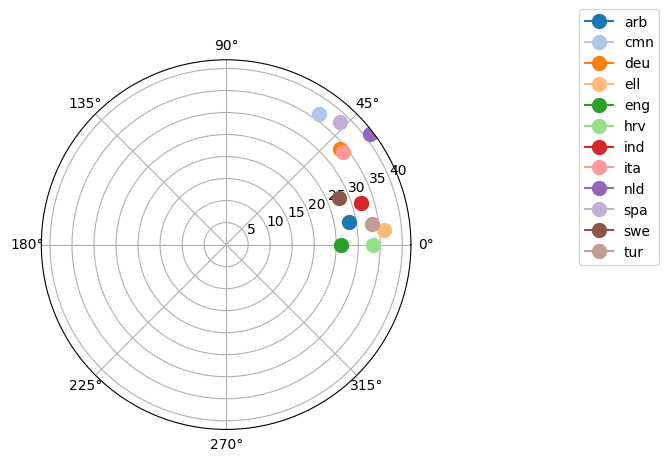

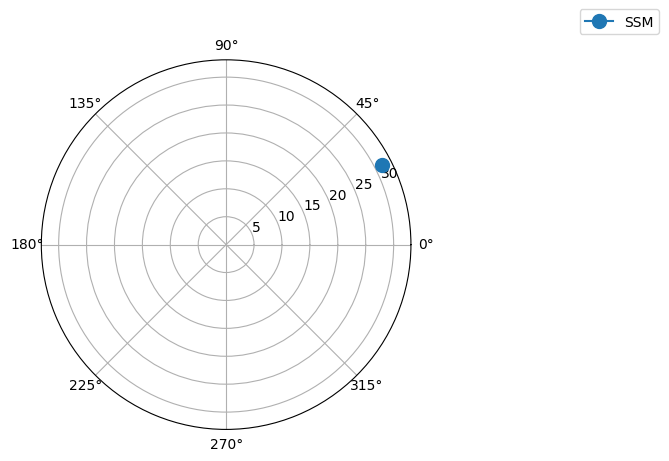

In [20]:
cg01_res = circumplex.ssm_analyse(
    satp.query("Recording == 'CG01'"),
    scales,
    grouping=["Language"],
    grouped_angles=ang_dict,
)
cg01_all = circumplex.ssm_analyse(satp.query("Recording == 'CG01'"), scales)

cg01_res.plot()
plt.show()
cg01_all.plot()
plt.show()